# Homographies

In [1]:
%load_ext autoreload
%autoreload 2

import os
import cv2
import numpy as np

from typing import List

import matplotlib.pyplot as plt

from dt_computer_vision.camera import CameraModel, Pixel

from dt_computer_vision.camera.calibration.extrinsics.boards import CalibrationBoard8by6
from dt_computer_vision.camera.calibration.extrinsics.chessboard import find_corners
from dt_computer_vision.camera.calibration.extrinsics.rendering import draw_corners
from dt_computer_vision.camera.calibration.extrinsics.ransac import estimate_homography

In [2]:
this_dir: str = os.path.abspath('')
assets_dir: str = os.path.join(this_dir, "..", "assets", "extrinsics", "scenario0")
image_fpath: str = os.path.join(assets_dir, "frame0_distorted.jpg")
image: np.ndarray = cv2.imread(image_fpath)
board = CalibrationBoard8by6

camera_properties = {
    "width": 640,
    "height": 480,
    "K": [[295.79606866959824, 0.0, 321.2621599038631],
          [0.0, 299.5389048862878, 241.73616515312332],
          [0.0, 0.0, 1.0]],
    "D": [-0.23543978771661125,
          0.03637781479419574,
          -0.0033069818601306755,
          -0.0012140708179525926,
          0.0],
    "P": [[201.14027404785156, 0.0, 319.5586620845679, 0.0],
          [0.0, 239.74398803710938, 237.60151004037834, 0.0],
          [0.0, 0.0, 1.0, 0.0]]
}

camera = CameraModel(**camera_properties)

assert image.shape == (480, 640, 3)

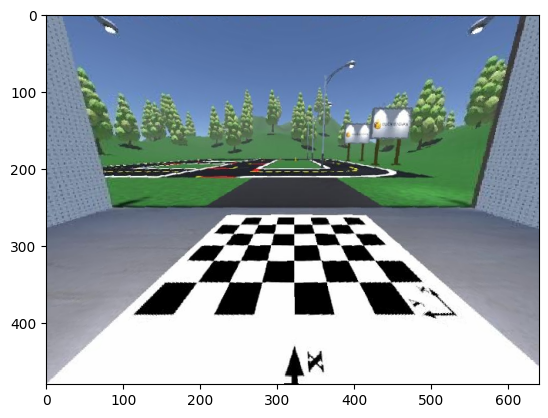

In [3]:
# rectify image
image = camera.rectifier.rectify(image)
rectified = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(rectified)

In [4]:
# find corners
corners: List[Pixel] = find_corners(image, board)
print(f"Found {len(corners)} corners.")
assert len(corners) == (board.columns - 1) * (board.rows - 1)

Found 35 corners.


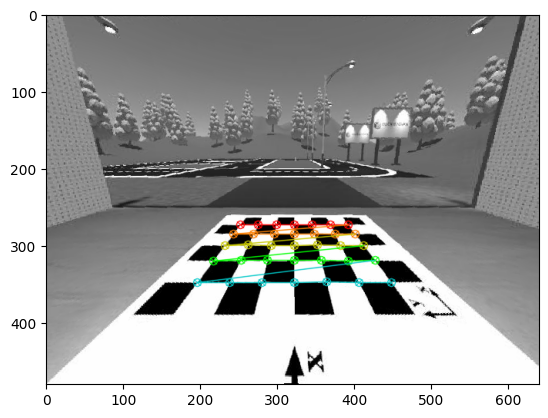

In [5]:
# draw detected corners on top of the image
image_w_corners = draw_corners(image, board, corners)
image_w_corners_rgb = cv2.cvtColor(image_w_corners, cv2.COLOR_BGR2RGB)
plt.imshow(image_w_corners_rgb)

In [6]:
# estimate homography
H = estimate_homography(corners, board, camera)

In [7]:
print(H.round(8).tolist())

[[0.00073717, 0.16619657, 0.45546919], [-0.58939945, 0.00141578, 0.00114574], [0.00041238, 4.78708892, 1.0]]


## Camera <-> Homography dependencies

In [8]:
from dt_computer_vision.camera.homography import ResolutionDependentHomography, ResolutionIndependentHomography

# resolution-dependent homography
Hv2x: ResolutionDependentHomography = ResolutionDependentHomography.read(H)

# resolution-independent homography
Hi2x: ResolutionIndependentHomography = Hv2x.camera_independent(camera)

# back to resolution-dependent homography
Hv2x_: ResolutionDependentHomography = Hi2x.camera_specific(camera)

# compare
print(Hv2x.round(8).tolist())
print(Hi2x.round(8).tolist())
print(Hv2x_.round(8).tolist())

[[0.00073717, 0.16619657, 0.45546919], [-0.58939945, 0.00141578, 0.00114574], [0.00041238, 4.78708892, 1.0]]
[[0.00114461, -4.8401959, -0.10215602], [-0.9428559, -3.86104891, -0.80519543], [0.00041238, 4.78708892, 1.0]]
[[0.00073717, 0.16619657, 0.45546919], [-0.58939945, 0.00141578, 0.00114574], [0.00041238, 4.78708892, 1.0]]
